# 16. 흐린 사진을 선명하게

### 사전학습

1. HR(High resolution) : 고해상도 이미지
2. LR(Low resolution) : 저해상도 이미지
3. Super Resolution : 저해상도 이미지를 고해상도 이미지로 변환 하는 것

3. Bicubic interpolation : 쌍삼차보간법
* 삼차보간법을 2차원으로 확장시킨 것이 쌍삼차보간법.
* 쌍삼차보간법은 16(=4x4)개의 점을 참조함.
* opencv에서 제공
![Screenshot from 2021-03-13 09-05-29](https://user-images.githubusercontent.com/60597598/111010944-4bef9100-83db-11eb-80d9-31ae43d8f5c7.png)

4. SRCNN : 3개 conv layer CNN
![Screenshot from 2021-03-13 08-56-32](https://user-images.githubusercontent.com/60597598/111010490-0e3e3880-83da-11eb-980b-46372cb01a98.png)

5. SRGAN : GAN을 사용한 생성자 판별자 CNN
![Screenshot from 2021-03-13 08-54-04](https://user-images.githubusercontent.com/60597598/111010416-c9b29d00-83d9-11eb-91b3-414a83a6acf8.png)

# 프로젝트 1 : 직접 고른 이미지로 SRGAN 실험하기

## Step 1. 필요한 모듈 import 하기

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

## Step 2. 이미 학습된 SRGAN 불러오기

In [2]:
import tensorflow as tf
import os

model_file = os.getenv('HOME')+'/aiffel/super_resolution/srgan_G.h5'
srgan = tf.keras.models.load_model(model_file)

아래 코드와 같이 테스트 과정을 진행하는 함수를 간단하게 정의하고, 이 함수를 이용해 이전에 사용했던 이미지에 대해 SRGAN의 고해상도 결과를 생성

## Step 3. SRGAN 함수로 정의하기

In [3]:
def apply_srgan(image):
    image = tf.cast(image[np.newaxis, ...], tf.float32)
    sr = srgan.predict(image)
    sr = tf.clip_by_value(sr, 0, 255)
    sr = tf.round(sr)
    sr = tf.cast(sr, tf.uint8)
    return np.array(sr)[0]

# 프로젝트 1-1. 
### 1. High_Resolution_Image_Load
* (적당히) 높은 해상도를 가진 이미지를 검색해서 한 장 고른 후 저장하고 불러옵니다.
* 빨간문 이미지로 테스트.

In [4]:
img_path = os.getenv('HOME')+'/aiffel/super_resolution/door.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_door = cv2.imread(img_path)
img_door = cv2.cvtColor(img_door, cv2.COLOR_BGR2RGB)
#print(img_door.shape)

### Super Resolution 결과를 평가하는 함수 정의하기
### PSNR과 SSIM
* PSNR 수치가 높을수록 원본 영상에 비해 손실이 적다
* SSIM값이 높을수록 원본 영상의 품질에 가깝다는 의미
* PSNR은 상한값이 없고, SSIM은 0~1 사이의 값을 가지기 때문에 각각 inf와 1이 계산된다.

In [5]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

print("**동일 이미지 비교**")
print("PSNR :", peak_signal_noise_ratio(img_door, img_door))
print("SSIM :", structural_similarity(img_door, img_door, multichannel=True))

**동일 이미지 비교**
PSNR : inf
SSIM : 1.0


/home/aiffel-dj17/anaconda3/envs/aiffel/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:160: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


### bicubic interpolation으로 downsample함수 만들기

In [6]:
def interpolation_downsample(image, n):
    downsample = cv2.resize(
        image,
        dsize=(image.shape[1]//n, image.shape[0]//n)
    )

    return downsample

### bicubic interpolation으로 upsample함수 만들기

In [7]:
def interpolation_upsample(image, n):
    upsample = cv2.resize(
        image,
        dsize=(image.shape[1]*n, image.shape[0]*n),
        interpolation=cv2.INTER_CUBIC
    )
    return upsample

### 원본 이미지 확인

In [8]:
print(img_door.shape)

(640, 458, 3)


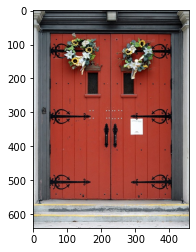

In [9]:
plt.imshow(img_door)
plt.show()

### 2. bicubic interpolation으로 downsample 하기
* 불러온 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 1/4로 줄입니다. cv2.resize()를 사용해 봅시다.

In [10]:
lr4_door = interpolation_downsample(img_door, 4)

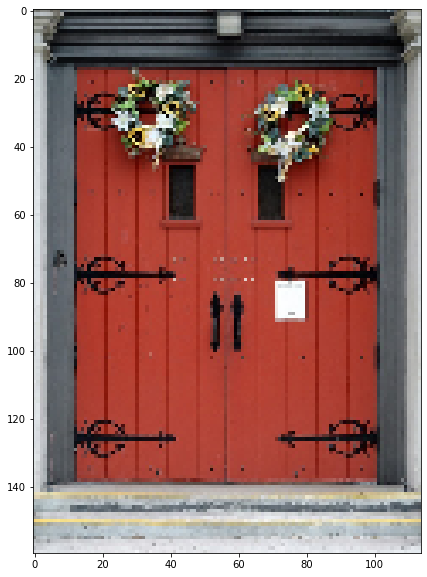

In [11]:
plt.figure(figsize=(10,10))
plt.imshow(lr4_door)
plt.show()

### 3. SRGAN
* 줄인 저해상도 이미지를 입력으로 SRGAN을 이용해 고해상도 이미지를 생성합니다.

In [12]:
srgan_door = apply_srgan(lr4_door)

### 4. bicubic interpolation으로 upsample 하기
* 2.의 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 다시 4배로 늘립니다. 마찬가지로 cv2.resize()를 사용해 봅시다.

In [13]:
bicubic_door = interpolation_upsample(lr4_door,4)

###  5. 시각화
* 3개 이미지(4.의 Bicubic의 결과, 3.의 SRGAN의 결과, 1.의 원래 고해상도 이미지)를 나란히 시각화합니다.

In [14]:
images = [img_door, bicubic_door, srgan_door]
titles = ["HR", "Bicubic", "SRGAN"]

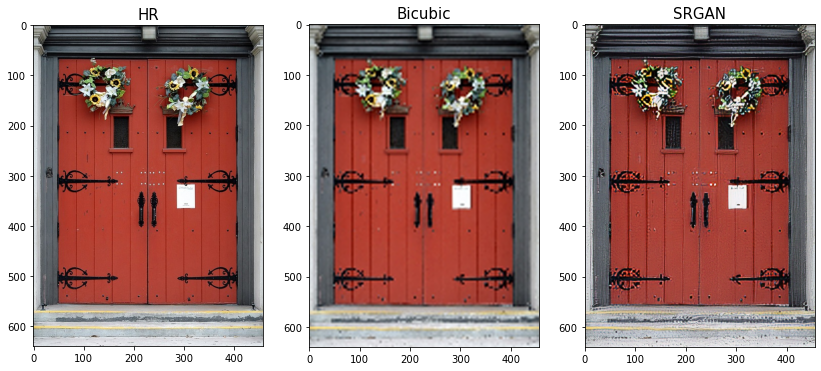

In [15]:
plt.figure(figsize=(14,18))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(images[i])
    plt.title(titles[i] , fontsize=15)

### 6. 평가하기
* 각 이미지들을 PSNR과 SSIM 수치로 나타내 보았다.
* 처음에 원본이미지, bicubic이미지, srgan이미지를 PSNR과 SSIM함수에 넣었을 때 오류가 났다.
* 원인을 분석해보니 srgan 이미지의 가로 길이가 2만큼 길어서 오류가 났다.
* cv2.resize()를 사용하여 조절해 주었다.
* DIV2K 데이터셋에서 학습된 SRGAN모델로 Super Resolution했을 때 육안으로 봤을 땐 좀 더 선명했다.
* 하지만 색감이 원본보다 조금 어두운 느낌여서 다른 점을 알 수 있었다.
* 그리고 SRGAN 모델은 PSNR점수와 SSIM 점수가 Bicubic 모델모다 낮았다.
* 그럼에도 고해상도 이미지를 만들어낸다.
* PSNR과 SSIM과 같은 고전적인 metric은 blurry한 복원을 가져오더라도 low-frequency 를 잘 복원할 경우 좋은 결과라고 판정하게 된다. 즉, high-frequency를 측정하는 데는 취약하다.
* 그러면 어떤 평가지표로 평가해야 할까?
* 그래서 논문에선 MOS 지표로 평가했다.
* 블로그 참조(https://huni-learning.tistory.com/2)
* 논문 참조 (SRGAN : Photo-Realistic Single Image Super-Resolution Using a Generative Adversarial Network)

![Screenshot from 2021-03-13 08-09-31](https://user-images.githubusercontent.com/60597598/111008010-86553000-83d3-11eb-9df1-ab70f24e6b5d.png)

### MOS 지표란?
* 사람이 직접 점수를 메긴 것이다.
* 블로그 참조(https://bskyvision.com/508)

![Screenshot from 2021-03-13 08-34-44](https://user-images.githubusercontent.com/60597598/111009456-029d4280-83d7-11eb-8cac-80f845cde0da.png)

In [16]:
print(img_door.shape)
print(bicubic_door.shape)
print(srgan_door.shape)

(640, 458, 3)
(640, 456, 3)
(640, 456, 3)


In [17]:
img_door = cv2.resize(img_door, (456, 640))
bicubic_door= cv2.resize(bicubic_door, (456, 640))

In [18]:
print(img_door.shape)
print(bicubic_door.shape)
print(srgan_door.shape)

(640, 456, 3)
(640, 456, 3)
(640, 456, 3)


In [19]:
images = [img_door, bicubic_door, srgan_door]
titles = ["HR", "Bicubic", "SRGAN"]

In [20]:
# 각 이미지에 대해 PSNR을 계산하고 반올림합니다.
psnr = [round(peak_signal_noise_ratio(img_door, i), 3) for i in images]
# 각 이미지에 대해 SSIM을 계산하고 반올림합니다.
ssim = [round(structural_similarity(img_door, i, multichannel=True), 3) for i in images]

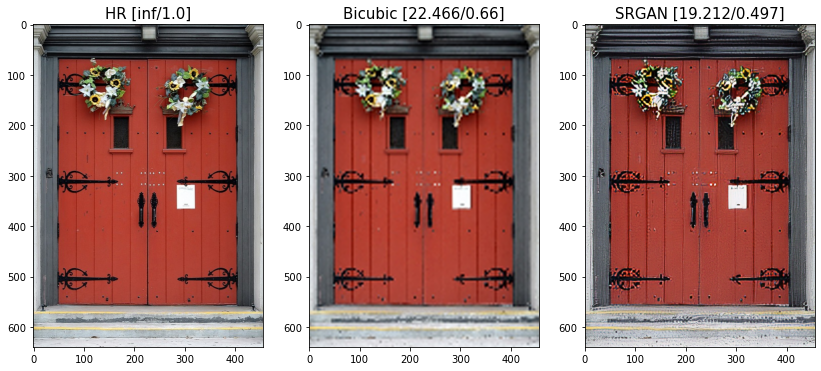

In [21]:
plt.figure(figsize=(14,18))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(images[i])
    plt.title(titles[i] + f" [{psnr[i]}/{ssim[i]}]", fontsize=15)

* SRGAN이 문은 잘 복원했지만 꽃은 좀 인위적으로 복원한 것 같다.

# 프로젝트 1-2. 
### 1. Low_Resolution_Image_Load
* (적당히) 낮은 해상도를 가진 이미지를 검색해서 한 장 고른 후 저장하고 불러옵니다.
* 이미지를 bicubic_downsample하여 저해상도로 만들고 저장하여 사용함.

In [22]:
img_path = os.getenv('HOME')+'/aiffel/super_resolution/orig.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig = cv2.imread(img_path)

In [23]:
lr_img = interpolation_downsample(img_orig, 3)
cv2.imwrite(os.getenv('HOME')+'/aiffel/super_resolution/lr_img.jpg', lr_img)

True

In [25]:
img_path = os.getenv('HOME')+'/aiffel/super_resolution/lr_img.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
lr_img = cv2.imread(img_path)
lr_img = cv2.cvtColor(lr_img, cv2.COLOR_BGR2RGB)

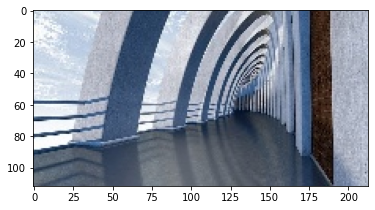

In [26]:
plt.figure(figsize=(6,8))
plt.imshow(lr_img)
plt.show()

### 2. SRGAN
* 불러온 이미지를 입력으로 SRGAN을 이용해 고해상도 이미지를 생성합니다. 이전에 사용한 apply_srgan 함수를 사용하면 쉽습니다.

In [27]:
srgan_img = apply_srgan(lr_img)

### 3. bicubic interpolation
* 1.에서 불러온 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 다시 4배로 늘립니다. cv2.resize()를 사용해 봅시다.

In [28]:
bicubic_img=interpolation_upsample(lr_img, 4)

### 4. 시각화
* 2개 이미지(3.의 Bicubic의 결과, 2.의 SRGAN의 결과)를 나란히 시각화합니다. 각 이미지의 제목에 어떤 방법에 대한 결과인지 표시해 주세요. 이전 시각화에 사용했던 코드를 참고하면 어렵지 않습니다.

In [29]:
images = [bicubic_img, srgan_img]
titles = ["Bicubic", "SRGAN"]

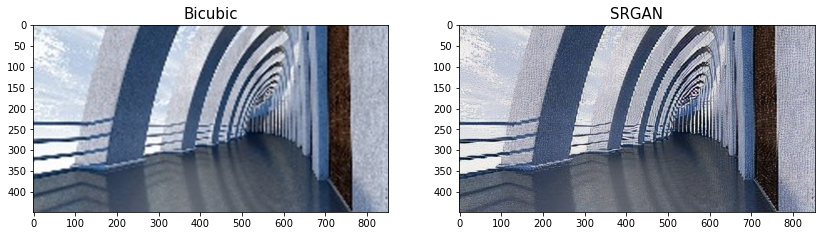

In [30]:
plt.figure(figsize=(14,8))
for i in range(2):
    plt.subplot(1,2,i+1)
    plt.imshow(images[i])
    plt.title(titles[i] , fontsize=15)

### 5. 평가하기
* 입력 이미지가 저해상도여도 전체 픽셀 수가 500000이상 정도로 크면 SRGAN 모델에 학습할 때 오류가 났다.
* 원인을 분석해보니 입력 이미지 픽셀이 500000 이면 출력 이미지는 x4가 되서 너무 큰 값이 나와 오류가 나는 것 같다.
* 때문에 입력 이미지 사이즈를 줄이는 작업으로 오류를 해결했다.
* SRGAN은 이런 down_sample작업을 거치더라도 입력 이미지가 train_dataset에 유사한 것이 있었는지의 유무에 따라 출력이미지 복원 결과가 좋아진다.
* 그리고 SRGAN은 너무 심하게 down_sample된 이미지는 super_resolution 결과가 좋지 않았다.
* 기둥과 같은 건물 관련 이미지를 넣었을 때 SRGAN 결과가 좋았다.

# 프로젝트 2 : SRGAN을 이용해 고해상도 gif 생성하기

### 1. gif 파일 불러오기   
* wine gif를 선택      

In [31]:
import cv2
gif_path = os.getenv('HOME')+'/aiffel/super_resolution/wine_lr.gif'
# 다운받은 파일의 경로를 설정해 주세요.
gif = cv2.VideoCapture(gif_path)

### 2. 프레임별 Super Resolution 진행하기   
* Bicubic, SRGAN 이라는 빈 리스트에 Super Resolution 결과를 저장함.

In [32]:
isTrue = True
frames = []
Bicubic =[]
SRGAN = []
while isTrue:
    isTrue, frame = gif.read()
    if isTrue:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)
        # 프레임별 Super Resolution 진행하기
        Bicubic.append(interpolation_upsample(frame, 4))
        SRGAN.append(apply_srgan(frame))

print("frame 수 :", len(frames))
print("frame 크기 :", (frames[0].shape))
print("Bicubic_frame 수 :", len(Bicubic))
print("frame 크기 :", (Bicubic[0].shape))
print("SRGAN_frame 수 :", len(SRGAN))
print("SRGAN_frame 크기 :", (SRGAN[0].shape))

frame 수 : 13
frame 크기 : (340, 355, 3)
Bicubic_frame 수 : 13
frame 크기 : (1360, 1420, 3)
SRGAN_frame 수 : 13
SRGAN_frame 크기 : (1360, 1420, 3)


* 입력 이미지가 340, 355로 조금 크긴 하지만 다행히 학습이 잘 되었다.

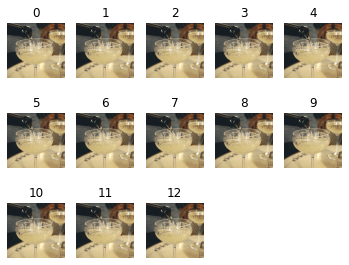

In [33]:
plt.figure(figsize=(6,8))
for i in range(13):
    plt.subplot(5,5,i+1)
    plt.axis('off')
    plt.imshow(frames[i])
    plt.title(i)
    


### 3. 프레임을 합쳐 gif 만들기 및 표시하기
* imageio모듈로 gif 저장

In [36]:
import imageio
from IPython.display import Image as show_gif

imageio.mimsave(os.getenv('HOME')+'/aiffel/super_resolution/wine_Bicubic.gif', Bicubic)
#show_gif(os.getenv('HOME')+'/aiffel/super_resolution/wine_Bicubic.gif', width=800)

In [37]:
import imageio

imageio.mimsave(os.getenv('HOME')+'/aiffel/super_resolution/wine_SRGAN.gif', SRGAN)
#show_gif(os.getenv('HOME')+'/aiffel/super_resolution/wine_SRGAN.gif', width=800)

### 4. gif 링크
* show_gif를 할 경우 주피터 노트북엔 표시가 되지만 파일이 너무 커져서 github에 올라가지 않음. 
* 그래서 따로 구글 드라이브 링크를 남김. 

## wine_SRGAN.gif 링크
* https://drive.google.com/file/d/1z9FU8x6NMSkDOsJQioIR2RSJlHSnMNo1/view?usp=sharing

## wine_Bicubic.gif 링크
* https://drive.google.com/file/d/1buG7W-u_Gji25I0uXJyTwfY5SItk0Bun/view?usp=sharing

### gif 평가하기
* 와인병과 유리잔의 선명도가 SRGAN이 더 선명한 것을 육안으로 확인할 수 있었다.

# 마치며...
* 처음엔 PSNR과 SSIM을 출력할 때 오류가 생겼다. 이는 이미지 사이즈에 대한 오류였다. 노드 예제에서는 여기에서 오류가 안났던 것 같은데 왜 오류가 나는지 좀 더 알아보고 싶다.
* 프로젝트 1-2는 생각보다 이미지 선택이 중요했다. bicuvic과 srgan의 눈에 띄는 차이를 확인하고 싶었는데 그게 힘들었다. 10장이상의 이미지를 테스트 했을 때 눈에 좀 구분되는 결과가 나왔다.
* gif 이미지 생성은 처음에 book gif로 했는데 이미지 장 수도 23장으로 많고 원본도 열었을 때 오류가 나고 프레임별로 확인했을 때 마지막 이미지에 흰색 사진이  들어있어 별로 좋지 않은 데이터셋인 것을 확인했다. 그래서 wine gif로 super resolution을 했더니 결과가 잘 나왔다.